In [17]:
import os
import matplotlib.pyplot as plt

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_nature.drivers import Molecule

from quantum_serverless import QuantumServerless
from quantum_serverless.library import efficient_ansatz_vqe_sweep

### Overview

This is overview architecture of this demo

![parameter sweep](images/parameters_sweep_vqe_efficient_ansatz.png)

### Implementation

Let's see how we can implement this.
For full implementation [see here]().

```python
# quantum_serverless/library/efficient_ansatz_vqe_sweep.py

from quantum_serverless import run_qiskit_remote, get


@run_qiskit_remote()
def hardware_efficient_ansatz(
    molecule: Molecule,
    initial_point: Union[List[float], np.ndarray],
    options: Optional[Options] = None,
    service: Optional[Union[QiskitRuntimeService, Dict[str, Any]]] = None,
):
    driver = PySCFDriver.from_molecule(molecule=molecule, ...)
    es_problem = ElectronicStructureProblem(driver, ...)
    ansatz = ...
    operator = qubit_converter.convert(es_problem.second_q_ops(), ...)
    optimizer = COBYLA(maxiter=500)
    ...
    
    with Session(service=service) as session:
        estimator = Estimator(session=session, options=options)

        vqe = EstimatorVQE(
            estimator=estimator,
            circuit=ansatz,
            optimizer=optimizer,
            init_point=initial_point,
        )

        vqe_result = vqe.compute_minimum_eigenvalue(operator)
       
    return vqe_result.optimal_value


def efficient_ansatz_vqe_sweep(
    molecules: List[Molecule],
    initial_points: Optional[List[List[float]]] = None,
    service: Optional[QiskitRuntimeService] = None,
    backends: Optional[List[IBMQBackend]] = None,
):
    ...
    function_references = [
        hardware_efficient_ansatz(
            molecule=molecule,
            initial_point=initial_point,
            service=service,
        )
        for molecule, initial_point in zip(molecules, initial_points)
    ]

    return get(function_references)
```

### Initialization

In [18]:
# default initialization
serverless = QuantumServerless()

# from configuration object
config = {"providers": []}
serverless = QuantumServerless(config)

# from config file
serverless = QuantumServerless.load_configuration("./serverless_config.json")

serverless

<QuantumServerless: providers [local, ibm], clusters [local, ibm_remote]>

In [19]:
# get available providers
serverless.providers()

[<Provider: local>, <Provider: ibm>]

In [22]:
service = QiskitRuntimeService()

In [ ]:
names = ["ibmq_qasm_simulator", "ibmq_qasm_simulator", "ibmq_qasm_simulator"]
backends = [service.backend(name) for name in names]

In [ ]:
%%capture

with serverless:  # or serverless.provider("ibm")
    energies = efficient_ansatz_vqe_sweep(
        molecules=[
            Molecule(geometry=[("H", [0.0, 0.0, 0.0]), ("Li", [0.0, 0.0, 1.0])], charge=0, multiplicity=1),
            Molecule(geometry=[("H", [0.0, 0.0, 0.0]), ("Li", [0.0, 0.0, 1.5])], charge=0, multiplicity=1),
            Molecule(geometry=[("H", [0.0, 0.0, 0.0]), ("Li", [0.0, 0.0, 2.0])], charge=0, multiplicity=1),
        ],
        initial_points=[
            [0.1, 0.1, 0.1, 0.1],
            [0.01, 0.01, 0.01, 0.01],
            [0.001, 0.001, 0.001, 0.001],
        ],
        service=service,
        backends=backends,
        optimization_level = 1,
        resilience_level = 1,
        shots=4000
    )

In [43]:
print("Energies: ", [e[0] for e in energies])
print("Shifts: ", [e[1] for e in energies])
print("Energy + shift: ", [e[0] + e[1] for e in energies])

Energies:  [-0.7321938981553707, -1.088976112107252, -0.712321087454812]
Shifts:  [-6.609784771130333, -6.781951626949075, -6.870414678425503]
Energy + shift:  [-7.341978669285704, -7.870927739056327, -7.582735765880315]


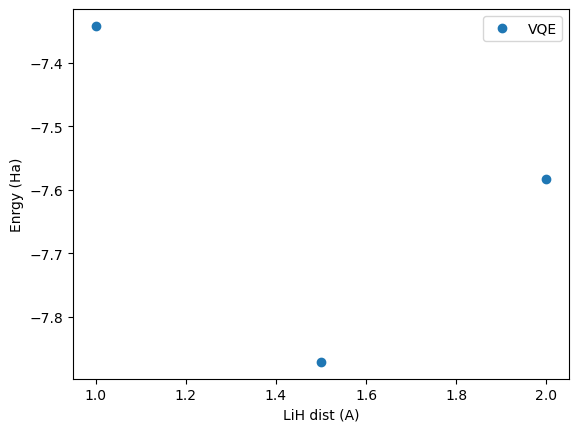

In [44]:
dist = [1.0,1.5,2.0]
plt.plot(dist, [e[0] + e[1] for e in energies], 'o', label = 'VQE')
plt.xlabel('LiH dist (A)')
plt.ylabel('Enrgy (Ha)')
plt.legend()
plt.show()

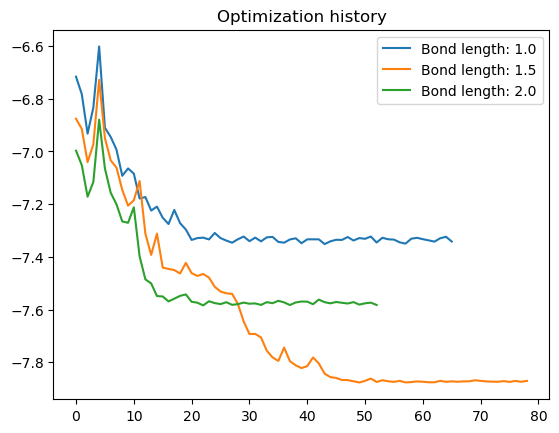

In [48]:
for i, bond_l in enumerate([1.0, 1.5, 2.0]):
    shift = energies[i][1]
    history = [h[1] + shift for h in energies[i][2]]
    plt.plot(history, label=f"Bond length: {bond_l}")

plt.title("Optimization history")
plt.legend()
plt.show()